In [9]:
import easyocr
import cv2
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [11]:
file_path = 'attachments/Positive Examples/TRIMBLE 290340.png'

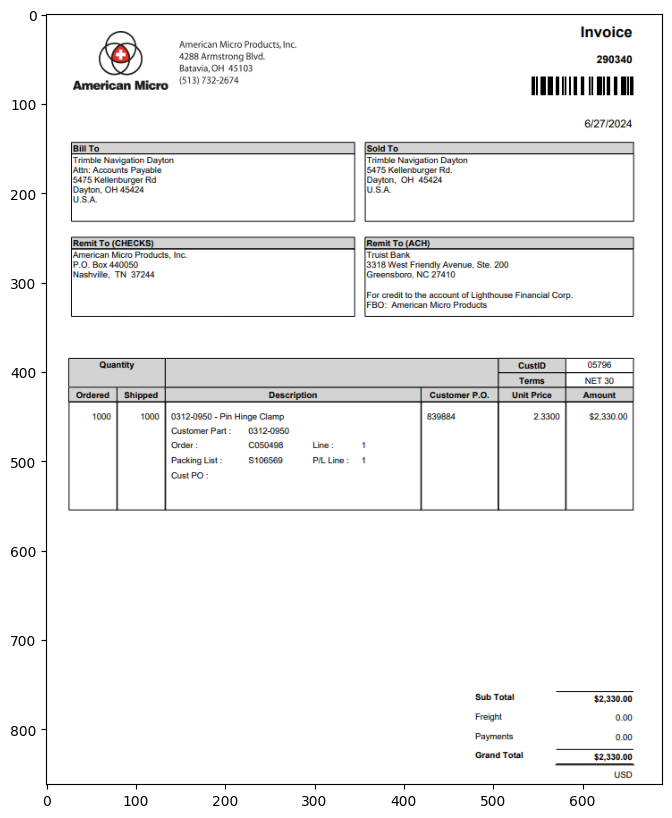

In [14]:
invoice_image = cv2.imread(file_path)
invoice_image = cv2.cvtColor(invoice_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(invoice_image)

True

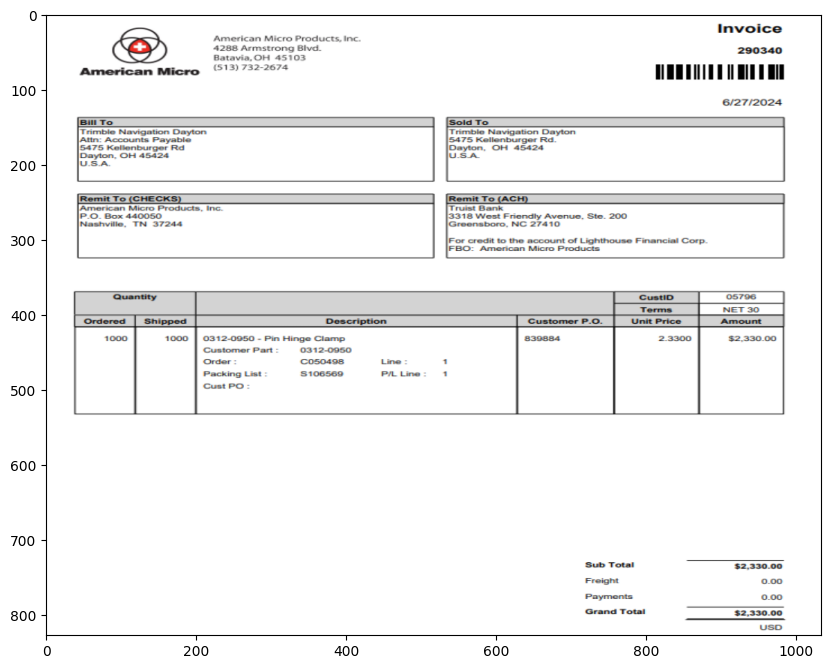

In [37]:
stretch_near = cv2.resize(invoice_image, (int(invoice_image.shape[0]*1.2), int(invoice_image.shape[1]*1.2)), interpolation = cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(stretch_near)
cv2.imwrite('attachments/Positive Examples/upscaled.png', stretch_near)

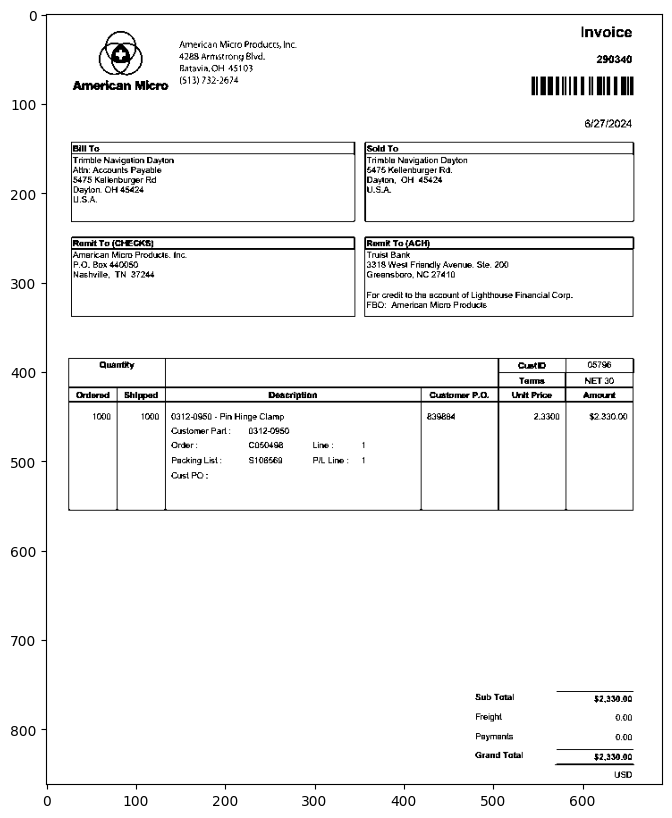

In [21]:
gray_image = cv2.cvtColor(invoice_image, cv2.COLOR_RGB2GRAY)
_, thresholded_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
denoised_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
dilated_image = cv2.dilate(denoised_image, kernel, iterations=1)
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
plt.figure(figsize=(10,10))
plt.imshow(eroded_image, cmap='gray')

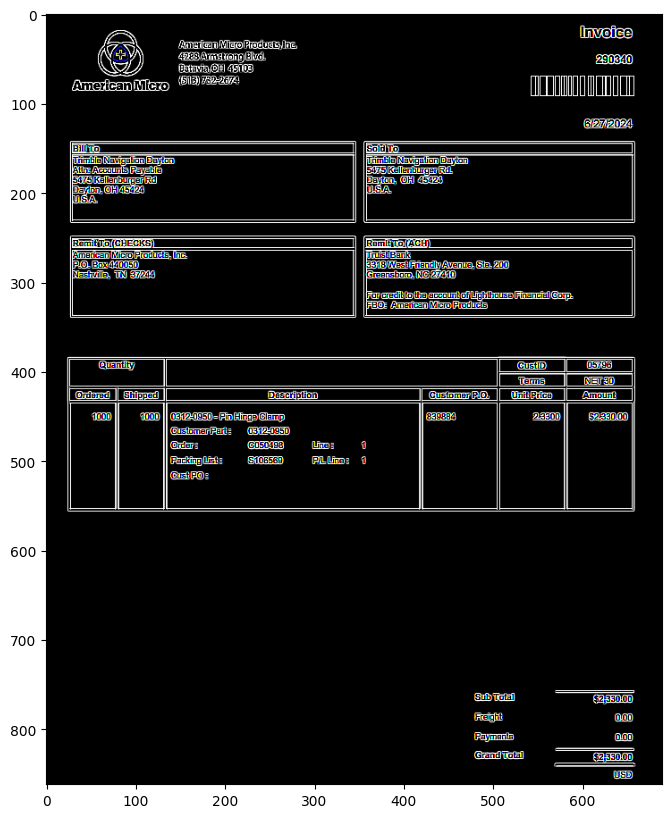

In [30]:
import numpy as np
kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
im = cv2.filter2D(invoice_image, -1, kernel)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(im)

In [74]:
reader = easyocr.Reader(['en'], verbose=False)
result = reader.readtext('attachments/Positive Examples/images/1020623.png')
content = ' '.join([text[1] for text in result])
print(content)

NORTH STATE FASTENER" PAST DUE INVOICE Date Number Page 4/19/2024 1020623 Remit To: North State Fastener Inc. 1300 Industrial Rd Ste 21 San Carlos CA  94070 United States Amenca Phone: 650-593-3288 TRIMBLE NAVIGATION LTD - SUNNYVALE TRIMBLE NAVIGATION LTD 5475 KELLENBURGER ROAD 4450 GIBSON DRIVE DAYTON OH 45424 United States of America TIPP CITY OH 45371 United States of America Emall: accounts_payablehelpdesk@trimble.com Tracking: 1Z1R7W540344267442 Customer ID Customer PO Salesperson Werms Due Date Packing Slip No Shipping Method 47900 835307 James Flemming Net 30 5/19/2024 21810 UPS Ground Line No Qty Shipped Item Description Customer Part Number Unit Price Extension SR7964 3/4-16X3 HX-CAP-SC-GR8-Z YEL 94728 2.30000 174.80 SR7964 3/4-16X3 HX-CAP-SC-GR8-Z YEL 94728 2.30000 27.60 Ncrth State Fastener Inc wamants that to the best oi cur kno leoge Matenalson Inig nave Dpp manuachuted EccomencaWn applicable instruction; and Subtotal: 202.40 3Ceciicaucne per PO emer 'shipment Eiclaims Mus

In [10]:
load_dotenv()

GPT_KEY = os.getenv('GPT_KEY')
GPT_ENDPOINT = os.getenv('GPT_ENDPOINT')
GPT_VERSION = os.getenv('GPT_VERSION')
GPT_DEPLOYMENT_NAME = os.getenv('GPT_DEPLOYMENT_NAME')

client = AzureOpenAI(
    api_key = GPT_KEY,
    api_version = GPT_VERSION,
    azure_endpoint = GPT_ENDPOINT
)

In [11]:
def invoice_classifier(content):
    query = f'''Does the below content indicate an Invoice statement ?
            {content}
            // Yes or No.'''

    response = client.chat.completions.create(
                        model = GPT_DEPLOYMENT_NAME,
                        messages = [
                            {
                                "role": "system",
                                "content": [
                                    {
                                    "type": "text",
                                    "text": ''' You are an helpful AI assistant. You help users to decide whether the content provided by them represents an invoice or not. You can judge the content based on certain invoice-related keywords. A few of them include:
                                    - Invoice Number
                                    - Invoice Date
                                    - Due Date
                                    - Bill To
                                    - Ship To
                                    - Customer
                                    - Order Number
                                    - Purchase Order (PO) Number
                                    - Terms
                                    - Line Item
                                    - Quantity
                                    - Unit Price
                                    - Total
                                    - Subtotal
                                    - Tax
                                    - Discount
                                    - Shipping Cost
                                    - Balance Due
                                    - Amount Paid
                                    - Remit To
                                    - Description
                                    - Net Price
                                    - Contact Information
                                    If you find a **good amount of keywords in the given content**, you can **return your verdict as Yes, else No**. Give your verdict in a simple Yes/No format.
                                    '''
                                    }
                                ]
                            },
                            {
                                "role" : "user",
                                "content": [
                                    {
                                    "type": "text",
                                    "text": f"{query}"
                                    },
                                ]
                            },
                        ],
                        max_tokens = 100,
                        temperature = 0,
                        top_p = 0.95,
                        seed=101
                    )

    return(response.choices[0].message.content)

In [13]:
import PyPDF2
def read_pdf(file_path):
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            content = ""
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
            content += page.extract_text()
        return content
    
    except Exception as e:
        print(f"Error reading PDF: {e}")
        return ""

In [14]:
import pdfplumber
def read_pdf_pdfPlumber(file_path):
    try:
        with pdfplumber.open(file_path) as pdf:
            text = ""
            for page in pdf.pages:
                text += page.extract_text() + "\n"
        return text
    except Exception as e:
        print(f"Failed to extract text from PDF: {e}")
        return ""

In [15]:
def read_pdf_as_image(file_path, image_path='attachments/Positive Examples/images/sample.png'):
    try:
        with pdfplumber.open(file_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                # Convert PDF page to image
                image = page.to_image()
                image.save(image_path)
                
                # Perform OCR on the image
                reader = easyocr.Reader(['en'], verbose=False)
                result = reader.readtext(image_path)
                content = ' '.join([text[1] for text in result])
                return content
            
    except Exception as e:
        print(f"Failed to extract text from PDF: {e}")
        return ""

In [19]:
def read_img(file_path):
    try:
        reader = easyocr.Reader(['en'], verbose=False)
        result = reader.readtext(file_path)
        content = ' '.join([text[1] for text in result])
        return content
    
    except Exception as e:
        print(f"Error reading Image: {e}")
        return ""

In [12]:
def read_img_azure_ocr(file_path):
    try:
        content = ''
        load_dotenv()
        subscription_key = os.environ["VISION_KEY"]
        endpoint = os.environ["VISION_ENDPOINT"]
        computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
        
        with open(file_path, "rb") as image_stream:
            ocr_result = computervision_client.recognize_printed_text_in_stream(image_stream)

        for region in ocr_result.regions:
            for line in region.lines:
                line_text = " ".join([word.text for word in line.words])
                content += line_text + ' '
        
        return content

    except Exception as e:
        print(f"Error reading Image: {e}")
        return ""

In [109]:
for pdf in os.listdir('attachments/Positive Examples/pdfs/'):
    file_path = f'attachments/Positive Examples/pdfs/{pdf}'
    content = read_pdf_pdfPlumber(file_path)
    isInvoice = invoice_classifier(content)

    if isInvoice == 'Yes':
        print(f"{pdf} is Invoice: {isInvoice}")
    else:
        content = read_pdf_as_image(file_path)
        isInvoice = invoice_classifier(content)
        print(f"{pdf} is Invoice: {isInvoice}")

1020623.pdf is Invoice: Yes
20240627145459374.pdf is Invoice: Yes
24100044779.pdf is Invoice: Yes
24100044780.pdf is Invoice: Yes
33377.pdf is Invoice: Yes
721141.pdf is Invoice: Yes
Arrow Invoices.pdf is Invoice: Yes
INSU-47699_2024_6_28_22_36_15.pdf is Invoice: Yes
Invoice 29077429 for PO 841829.PDF is Invoice: Yes
Invoice-291870.5-1.pdf is Invoice: Yes
Invoice_INV484574.pdf is Invoice: Yes
INV_0052120528.pdf is Invoice: Yes
Inv_96116_from_Wilmanco_Inc._8372.pdf is Invoice: Yes
Seco_Invoice_0000475386.pdf is Invoice: Yes
Statement_1759_from_Green_Circuits_Inc.pdf is Invoice: Yes
TRIMBLE 290340.pdf is Invoice: Yes


In [21]:
for img in os.listdir('attachments/Positive Examples/images/'):
    file_path = f'attachments/Positive Examples/images/{img}'
    content = read_img_azure_ocr(file_path)
    isInvoice = invoice_classifier(content)
    print(f"{img} is Invoice: {isInvoice}")

1020623.png is Invoice: Yes
20240627145459374.png is Invoice: Yes
24100044779.png is Invoice: Yes
33377.png is Invoice: Yes
721141.png is Invoice: Yes
INSU-47699_2024_6_28_22_36_15.png is Invoice: Yes
Invoice-291870.5-1.pdf.png is Invoice: Yes
Invoice_INV484574.png is Invoice: Yes
INV_0052120528.png is Invoice: Yes
Inv_96116_from_Wilmanco_Inc._8372.png is Invoice: Yes
sample.png is Invoice: Yes
Seco_Invoice_0000475386.png is Invoice: Yes
Statement_1759_from_Green_Circuits_Inc.pdf.png is Invoice: No
TRIMBLE 290340.png is Invoice: Yes


In [2]:
from dotenv import load_dotenv
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

load_dotenv()

True

In [3]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]

computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [8]:
local_image_path = "attachments/Positive Examples/images/33377.png"

# Open the image file
with open(local_image_path, "rb") as image_stream:
    # Perform OCR
    ocr_result = computervision_client.recognize_printed_text_in_stream(image_stream)

# Print the results
for region in ocr_result.regions:
    for line in region.lines:
        line_text = " ".join([word.text for word in line.words])
        print(line_text)

Number:
33377
IMBLE
SHIP
BILL
TO
MIAMI •VALLEY •PRECISION
c NC M ACH I N ING S p E c IA LISTS
1944 Byers Rd., Miamisburg, Oho 45342
937-866-1804 FAX 937-866-1806
TRIMBLE NAVIGATION LTD
5475 KELLENBURGER RD.
ATTN: ACCTS PAYABLE
DAYTON, OH 45424
USA
TERMS
Net 30 Days
INVOICE
Date:
Jun 28, 2024
AMERICAN FULFILLMENT CENTER
200.00 PN 0230-0390
MOUNT
Reference your PO#:
TO
4450 GIBSON DR
TIPP CITY, OH 45371
USA
SHIPPED VIA
Courier
7.20
FREIGHT CHARGES:
838183 LINE 2
TOTAL DUE
1 ,440.oo
$1,440.00
PLEASE REMIT PAYMENT TO:
MIAMI VALLEY PRECISION, INC.
P.o. BOX 63-2762
CINCNNATI, OHIO 45263-2762


In [3]:
import json
f = open('_metadata.json')
data = json.load(f)
icons = []
for i in data:
    icons.append(i['name'])
f.close()
print(icons)

['accessibility', 'accessibility-circle', 'add', 'add-bold', 'add-circle', 'add-heavy', 'address', 'advanced-instructions', 'alarm-add', 'alarm-off', 'alarm-on', 'alert', 'alert-outlined', 'align-bottom', 'align-center-horiz', 'align-center-vert', 'align-left', 'align-right', 'align-top', 'angle-90', 'antenna', 'apps', 'arc', 'arrow-back', 'arrow-down', 'arrow-down-circle', 'arrow-expand-diagonal-left', 'arrow-expand-diagonal-right', 'arrow-left', 'arrow-left-circle', 'arrow-next', 'arrow-right', 'arrow-right-circle', 'arrow-up', 'arrow-up-circle', 'artificial-intelligence', 'backup-restore-cloud', 'backup-restore-file', 'bar-graph', 'bar-graph-line', 'bar-graph-square', 'barcode', 'battery-0-horizontal', 'battery-0-vertical', 'battery-25-horizontal', 'battery-25-vertical', 'battery-50-horizontal', 'battery-50-vertical', 'battery-75-horizontal', 'battery-75-vertical', 'battery-charging-horizontal', 'battery-charging-vertical', 'battery-full-horizontal', 'battery-full-vertical', 'betwee

In [3]:
from openai import AzureOpenAI
import os
import base64
from dotenv import load_dotenv, dotenv_values
from mimetypes import guess_type

load_dotenv()

GPT_KEY = os.getenv('GPT_KEY')
GPT_ENDPOINT = os.getenv('GPT_ENDPOINT')
GPT_VERSION = os.getenv('GPT_VERSION')

client = AzureOpenAI(
    api_key = GPT_KEY,
    api_version = GPT_VERSION,
    azure_endpoint = GPT_ENDPOINT
)

# For converting it to a Browser understandable format.
def local_image_to_data_url(image_path):
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    return f"data:{mime_type};base64,{base64_encoded_data}"

query = "Describe the uploaded image."

# Support for more than one image. 
image_directory = "attachments/Positive Examples/images/"
uploaded_images = ["33377.png"]

data_urls = []

for img in uploaded_images:
    image_path = image_directory + img
    image_url = local_image_to_data_url(image_path)
    data_urls.append(image_url)

response = client.chat.completions.create(
                    model = os.getenv('GPT_DEPLOYMENT_NAME'),
                    messages = [
                        {
                            "role": "system",
                            "content": [
                                {
                                "type": "text",
                                "text": ''' You are an helpful                                 '''
                                }
                            ]
                        },
                        {
                            "role" : "user",
                            "content": [
                                {
                                "type": "text",
                                "text": f"{query}"
                                },
                                *[{
                                    "type": "image_url",
                                    "image_url": {
                                        "url" : f"{img_url}"
                                    }
                                    } for img_url in data_urls
                                ]
                            ]
                        },
                    ],
                    max_tokens = 2000,
                    temperature = 0.9,
                    top_p = 0.95,
                    seed=101
                )

print(response.choices[0].message.content)

The uploaded image is an invoice from Miami Valley Precision, a CNC machining specialist company. Here are the key details from the invoice:

- **Company Information:**
  - **Company Name:** Miami Valley Precision
  - **Address:** 1944 Byers Rd., Miamisburg, Ohio 45342
  - **Phone:** 937-866-1804
  - **Fax:** 937-866-1806

- **Invoice Details:**
  - **Invoice Number:** 33377
  - **Date:** June 28, 2024

- **Bill To:**
  - **Company Name:** Trimble Navigation Ltd
  - **Address:** 5475 Kellenburger Rd., ATTN: ACCTS PAYABLE, Dayton, OH 45424, USA

- **Ship To:**
  - **Company Name:** Trimble
  - **Address:** American Fulfillment Center, 4450 Gibson Dr, Tipp City, OH 45371, USA

- **Terms:** Net 30 Days
- **Shipped Via:** Courier

- **Items Listed:**
  - **Quantity:** 200.00
  - **Part Number:** PN 0230-0390
  - **Description:** Mount
  - **Price Per Item:** 7.20
  - **Total Price:** $1,440.00

- **Freight Charges:** Not specified

- **Reference PO#:** 838183 Line 2

- **Total Due:** $1,44